In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import scipy
from scipy.optimize import least_squares,differential_evolution
import time
from scipy import io
from scipy.stats import t
from scipy.signal import convolve

In [ ]:
data = scipy.io.loadmat('../data/trajectories.mat')

resp_rdw = pd.read_csv('../data/resp_rdw.csv', header=None).to_numpy().mean(axis=1)
resp_iid = pd.read_csv('../data/resp_iid.csv', header=None).to_numpy().mean(axis=1)
reslt = np.vstack([resp_iid,resp_rdw])

acc_rdw = pd.read_csv('../data/acc_rdw.csv', header=None).to_numpy().mean(axis=1)
acc_iid = pd.read_csv('../data/acc_iid.csv', header=None).to_numpy().mean(axis=1)

corrrslt = np.vstack([acc_iid,acc_rdw])

In [6]:
def getrslt(noise, nsmooth, nbias, data, indices):
    num_indices = len(indices)
    rmdl = np.zeros((2, num_indices))
    nmdl = np.zeros((2, num_indices))
    same = np.zeros((2, num_indices), dtype=bool)  # is same cond ?
    mpos = np.zeros((2, num_indices))  # mean position
    lpos = np.zeros((2, num_indices))  # last position
    n = 1000
    resp = np.zeros(n)
    mdls = [0, 1]
    for j in mdls:
        traind = data['iidind'][2:, ] if j == 0 else data['rdwind'][2:, ]
        for idx, tidx in enumerate(indices):
            invis = int(traind[0, tidx])  # - 1
            pos = traind[1:, tidx].copy()
            pos[-invis + 1:] = np.nan
            lastpos = pos[-invis]  # if invis > 0 else np.nan
            lpos[j, idx] = lastpos
            meanpos = np.nanmean(pos)
            mpos[j, idx] = meanpos
            same[j, idx] = meanpos * lastpos > 0
            nmdl[j, idx] = np.sign(meanpos if j == 0 else lastpos)

            for k in range(n):
                npos = pos + np.random.randn(len(pos)) * noise + np.random.randn() * nbias
                segment = npos[-((invis) + nsmooth): -(invis - 1)]
                resp[k] = np.sign(np.mean(segment))

            rmdl[j, idx] = np.sum(resp * nmdl[j, idx] > 0) / n
    return rmdl, nmdl, same, mpos, lpos
    
def calculate_rmse_matrices(data, nsmootharr, noisearr, nbiasarr, train_indices):
    rms = np.zeros((len(nsmootharr), len(noisearr), len(nbiasarr)))
    rmsiid = np.zeros_like(rms)
    rmsrdw = np.zeros_like(rms)
    minrms = float('inf')
    best_params = None
    start_time = time.time()

    for j, ns in enumerate(nsmootharr):
        for k, no in enumerate(noisearr):
            for l, nb in enumerate(nbiasarr):
                rmdl, nmdl, same, mpos, lpos = getrslt(no, ns, nb, data, train_indices)
                rmsiid[j, k, l] = np.sqrt(np.nanmean((corrrslt[0, train_indices] - rmdl[0, :]) ** 2))
                rmsrdw[j, k, l] = np.sqrt(np.nanmean((corrrslt[1, train_indices] - rmdl[1, :]) ** 2))
                rms[j, k, l] = np.sqrt(np.nanmean((corrrslt[:, train_indices].ravel() - rmdl.ravel()) ** 2))

                if rms[j, k, l] < minrms:
                    minrms = rms[j, k, l]
                    minrmdl = rmdl
                    best_params = (ns, no, nb)

    elapsed_time = time.time() - start_time
    print("Elapsed time: {:.2f} seconds".format(elapsed_time))

    return rms, rmsiid, rmsrdw, minrms, minrmdl, best_params,same

In [7]:

# Function to split indices into train and test
def split_indices(indices, n_test):
    test_indices = np.random.choice(indices, n_test, replace=False)
    train_indices = np.setdiff1d(indices, test_indices)
    return train_indices, test_indices

idx_same_ll = np.arange(0,50)
idx_same_rr = np.arange(150,200)

idx_op_lr = np.arange(50,100)
idx_op_rl = np.arange(100,150)

_, test_same_ll = split_indices(idx_same_ll, 0)
_, test_same_rr = split_indices(idx_same_rr, 0)
_, test_op_lr = split_indices(idx_op_lr, 0)
_, test_op_rl = split_indices(idx_op_rl, 0)

test_indices = np.hstack([test_same_ll, test_same_rr, test_op_lr, test_op_rl])
train_indices = np.setdiff1d(np.hstack([idx_same_ll, idx_same_rr, idx_op_lr, idx_op_rl]), test_indices)

In [ ]:

nsmootharr = np.arange(7)
noisearr = np.arange(7)
nbiasarr = np.arange(7)

rms, rmsiid, rmsrdw, minrms, minrmdl, best_params,same = calculate_rmse_matrices(data, nsmootharr, noisearr, nbiasarr, train_indices)
print("Minimum RMSE (Train):", minrms)
print("Best parameters for minimum RMSE (Train):", best_params)

In [56]:
# Testing on the last 8 trajectories (8 IID + 8 RDW)
# test_indices = np.arange(192, 200)

# Use the best parameters to test on the test set
def test_model(data, best_params, test_indices):
    ind= range(len(test_indices))
    ns, no, nb = best_params
    rmdl, nmdl, same, mpos, lpos = getrslt(no, ns, nb, data, test_indices)
    test_rmse = np.sqrt(np.nanmean((corrrslt[:, test_indices].ravel() - rmdl.ravel()) ** 2))
    return test_rmse

test_rmse = test_model(data, best_params, test_indices)
print("RMSE (Test):", test_rmse)

RMSE (Test): nan


C:\Users\Oleg\AppData\Local\Temp\ipykernel_21948\3637489129.py:9: RuntimeWarning: Mean of empty slice
  test_rmse = np.sqrt(np.nanmean((corrrslt[:, test_indices].ravel() - rmdl.ravel()) ** 2))


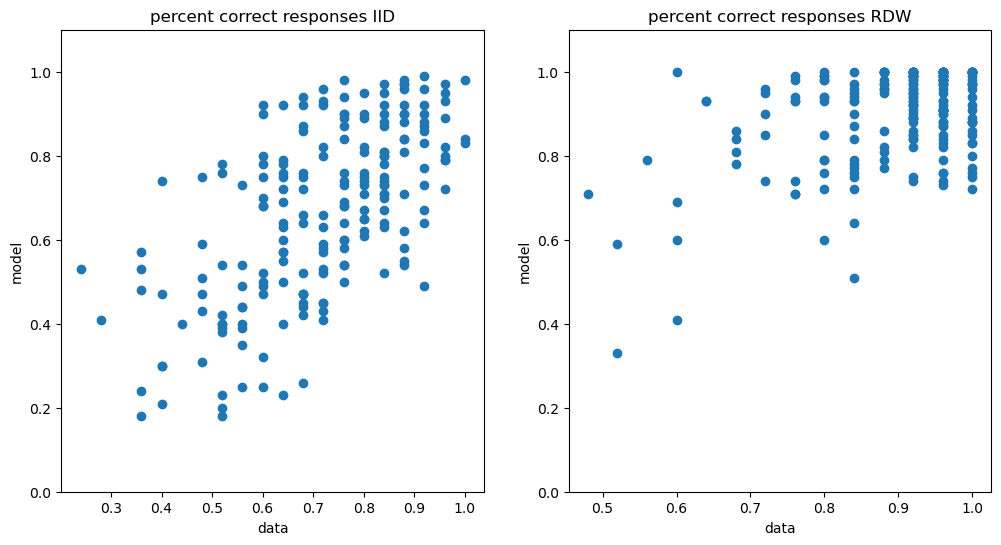

In [57]:
plt.figure(figsize=(12, 6))

# Scatter plot для IID
plt.subplot(1, 2, 1)
plt.scatter(corrrslt[0, :], minrmdl[0, :], marker='o')
plt.xlabel('data')
plt.ylabel('model')
plt.title('percent correct responses IID')
plt.ylim(0,1.1)
# Scatter plot для RDW
plt.subplot(1, 2, 2)
plt.scatter(corrrslt[1, :], minrmdl[1, :], marker='o')
plt.xlabel('data')
plt.ylabel('model')
plt.ylim(0,1.1)
plt.title('percent correct responses RDW')
plt.show()

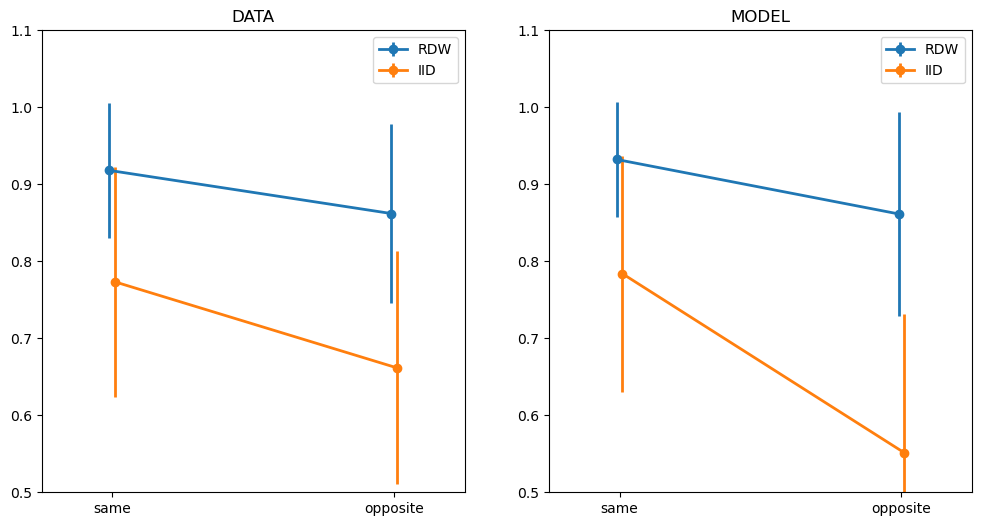

In [58]:
plt.figure(figsize=(12, 6))

# Data error bars
plt.subplot(1, 2, 1)
y1 = corrrslt[1, same[1, :]]
y0 = corrrslt[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='RDW')
y1 = corrrslt[0, same[0, :]]
y0 = corrrslt[0, ~same[0, :]]
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='IID')
plt.xticks([1, 2], ['same', 'opposite'])
plt.xlim([0.75, 2.25])
plt.ylim([0.5, 1.1])
plt.legend()
plt.title('DATA')

# Model error bars
plt.subplot(1, 2, 2)
y1 = minrmdl[1, same[1, :]]
y0 = minrmdl[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='RDW')
y1 = minrmdl[0, same[0, :]]
y0 = minrmdl[0, ~same[0, :]]
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='IID')
plt.xticks([1, 2], ['same', 'opposite'])
plt.xlim([0.75, 2.25])
plt.ylim([0.5, 1.1])
plt.legend()
plt.title('MODEL')
plt.show()

In [120]:
def cross_validation_ensure_all_in_test(idx_same_ll, idx_same_rr, idx_op_lr, idx_op_rl):
    results = []
    n = len(idx_same_ll)  

    for i in range(0, n, 4):
        test_indices = np.hstack([
            idx_same_ll[i:i+4], 
            idx_same_rr[i:i+4], 
            idx_op_lr[i:i+4], 
            idx_op_rl[i:i+4]
        ])
        
        train_indices = np.setdiff1d(np.hstack([idx_same_ll, idx_same_rr, idx_op_lr, idx_op_rl]), test_indices)
        
        nsmootharr = np.arange(7)
        noisearr = np.arange(7)
        nbiasarr = np.arange(7)

        rms, rmsiid, rmsrdw, minrms, minrmdl, best_params = calculate_rmse_matrices(data, nsmootharr, noisearr, nbiasarr, train_indices)
        
        test_rmse = test_model(data, best_params, test_indices)
        
        # results.append((minrms, best_params, test_rmse))
        results.append((minrms, best_params, test_rmse, test_indices))
    
    return results

results = cross_validation_ensure_all_in_test(idx_same_ll, idx_same_rr, idx_op_lr, idx_op_rl)


Elapsed time: 998.58 seconds
Elapsed time: 3535.74 seconds
Elapsed time: 3584.12 seconds
Elapsed time: 3583.75 seconds
Elapsed time: 3591.52 seconds
Elapsed time: 3581.93 seconds
Elapsed time: 3559.28 seconds
Elapsed time: 3572.85 seconds
Elapsed time: 3558.31 seconds
Elapsed time: 3559.80 seconds
Elapsed time: 3555.19 seconds
Elapsed time: 3577.28 seconds
Elapsed time: 3760.54 seconds


In [121]:
for i, (minrms, best_params, test_rmse, test_indices) in enumerate(results):
    print(f"Iteration {i+1}")
    print(f"Test indices: {test_indices}")
    print(f"Minimum RMSE (Train): {minrms}")
    print(f"Best parameters for minimum RMSE (Train): {best_params}")
    print(f"RMSE (Test): {test_rmse}\n")


Iteration 1
Test indices: [  0   1   2   3 150 151 152 153  50  51  52  53 100 101 102 103]
Minimum RMSE (Train): 0.14015403986794084
Best parameters for minimum RMSE (Train): (5, 4, 3)
RMSE (Test): 0.1610241635593863

Iteration 2
Test indices: [  4   5   6   7 154 155 156 157  54  55  56  57 104 105 106 107]
Minimum RMSE (Train): 0.14025136595475252
Best parameters for minimum RMSE (Train): (5, 4, 3)
RMSE (Test): 0.15505613902712784

Iteration 3
Test indices: [  8   9  10  11 158 159 160 161  58  59  60  61 108 109 110 111]
Minimum RMSE (Train): 0.14280598346373125
Best parameters for minimum RMSE (Train): (5, 2, 3)
RMSE (Test): 0.12634674511043015

Iteration 4
Test indices: [ 12  13  14  15 162 163 164 165  62  63  64  65 112 113 114 115]
Minimum RMSE (Train): 0.1415599715437887
Best parameters for minimum RMSE (Train): (5, 6, 2)
RMSE (Test): 0.1427920253375517

Iteration 5
Test indices: [ 16  17  18  19 166 167 168 169  66  67  68  69 116 117 118 119]
Minimum RMSE (Train): 0.1414567

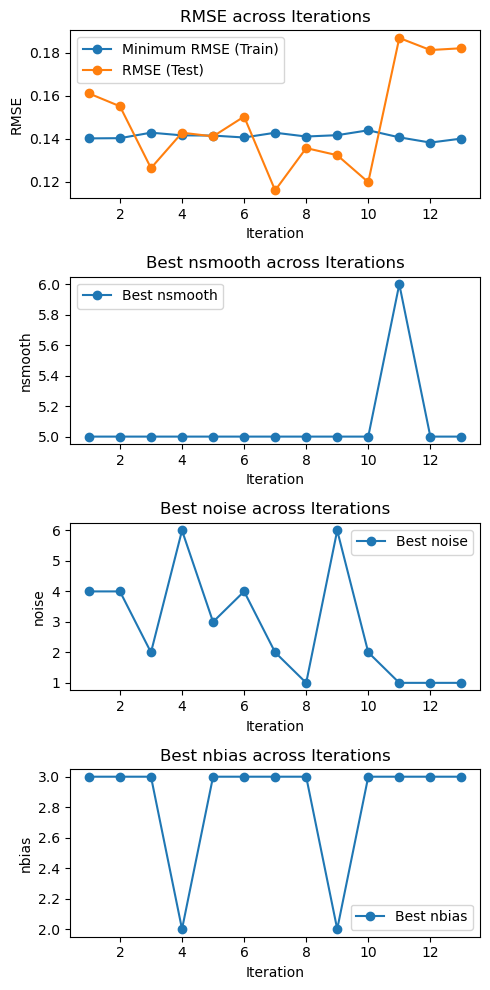

In [128]:
# Extract data for visualization
iterations = range(1, len(results) + 1)
minrms_values = [result[0] for result in results]
best_nsmooth = [result[1][0] for result in results]
best_noise = [result[1][1] for result in results]
best_nbias = [result[1][2] for result in results]
test_rmse_values = [result[2] for result in results]
test_indices_all = [result[3] for result in results]


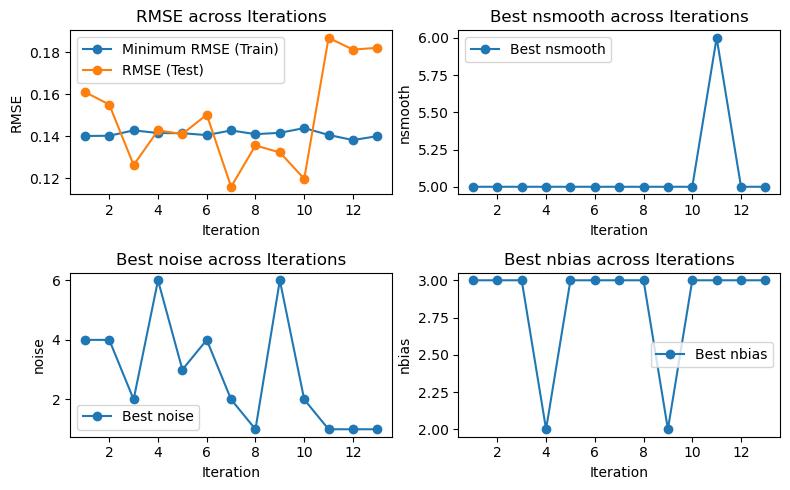

In [132]:

# Visualization of RMSE and best parameters across iterations
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# RMSE on training and test sets
axs[0, 0].plot(summary_df['Iteration'], summary_df['Minimum RMSE (Train)'], label='Minimum RMSE (Train)', marker='o')
axs[0, 0].plot(summary_df['Iteration'], summary_df['RMSE (Test)'], label='RMSE (Test)', marker='o')
axs[0, 0].set_title('RMSE across Iterations')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('RMSE')
axs[0, 0].legend()

# Best nsmooth
axs[0, 1].plot(summary_df['Iteration'], summary_df['Best nsmooth'], label='Best nsmooth', marker='o')
axs[0, 1].set_title('Best nsmooth across Iterations')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('nsmooth')
axs[0, 1].legend()

# Best noise
axs[1, 0].plot(summary_df['Iteration'], summary_df['Best noise'], label='Best noise', marker='o')
axs[1, 0].set_title('Best noise across Iterations')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('noise')
axs[1, 0].legend()

# Best nbias
axs[1, 1].plot(summary_df['Iteration'], summary_df['Best nbias'], label='Best nbias', marker='o')
axs[1, 1].set_title('Best nbias across Iterations')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('nbias')
axs[1, 1].legend()

plt.tight_layout()
plt.show()



In [123]:
# Print test indices for each iteration
for i, test_indices in enumerate(test_indices_all):
    print(f"Iteration {i+1} Test indices: {test_indices}")

Iteration 1 Test indices: [  0   1   2   3 150 151 152 153  50  51  52  53 100 101 102 103]
Iteration 2 Test indices: [  4   5   6   7 154 155 156 157  54  55  56  57 104 105 106 107]
Iteration 3 Test indices: [  8   9  10  11 158 159 160 161  58  59  60  61 108 109 110 111]
Iteration 4 Test indices: [ 12  13  14  15 162 163 164 165  62  63  64  65 112 113 114 115]
Iteration 5 Test indices: [ 16  17  18  19 166 167 168 169  66  67  68  69 116 117 118 119]
Iteration 6 Test indices: [ 20  21  22  23 170 171 172 173  70  71  72  73 120 121 122 123]
Iteration 7 Test indices: [ 24  25  26  27 174 175 176 177  74  75  76  77 124 125 126 127]
Iteration 8 Test indices: [ 28  29  30  31 178 179 180 181  78  79  80  81 128 129 130 131]
Iteration 9 Test indices: [ 32  33  34  35 182 183 184 185  82  83  84  85 132 133 134 135]
Iteration 10 Test indices: [ 36  37  38  39 186 187 188 189  86  87  88  89 136 137 138 139]
Iteration 11 Test indices: [ 40  41  42  43 190 191 192 193  90  91  92  93 140

In [124]:
# Print the results and create a summary table
summary_data = []

for i, (minrms, best_params, test_rmse, test_indices) in enumerate(results):
    print(f"Iteration {i+1}")
    print(f"Test indices: {test_indices}")
    print(f"Minimum RMSE (Train): {minrms}")
    print(f"Best parameters for minimum RMSE (Train): {best_params}")
    print(f"RMSE (Test): {test_rmse}\n")
    summary_data.append({
        'Iteration': i + 1,
        'Test indices': test_indices,
        'Minimum RMSE (Train)': minrms,
        'Best nsmooth': best_params[0],
        'Best noise': best_params[1],
        'Best nbias': best_params[2],
        'RMSE (Test)': test_rmse
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

Iteration 1
Test indices: [  0   1   2   3 150 151 152 153  50  51  52  53 100 101 102 103]
Minimum RMSE (Train): 0.14015403986794084
Best parameters for minimum RMSE (Train): (5, 4, 3)
RMSE (Test): 0.1610241635593863

Iteration 2
Test indices: [  4   5   6   7 154 155 156 157  54  55  56  57 104 105 106 107]
Minimum RMSE (Train): 0.14025136595475252
Best parameters for minimum RMSE (Train): (5, 4, 3)
RMSE (Test): 0.15505613902712784

Iteration 3
Test indices: [  8   9  10  11 158 159 160 161  58  59  60  61 108 109 110 111]
Minimum RMSE (Train): 0.14280598346373125
Best parameters for minimum RMSE (Train): (5, 2, 3)
RMSE (Test): 0.12634674511043015

Iteration 4
Test indices: [ 12  13  14  15 162 163 164 165  62  63  64  65 112 113 114 115]
Minimum RMSE (Train): 0.1415599715437887
Best parameters for minimum RMSE (Train): (5, 6, 2)
RMSE (Test): 0.1427920253375517

Iteration 5
Test indices: [ 16  17  18  19 166 167 168 169  66  67  68  69 116 117 118 119]
Minimum RMSE (Train): 0.1414567

In [125]:
summary_df

,Iteration,Test indices,Minimum RMSE (Train),Best nsmooth,Best noise,Best nbias,RMSE (Test)
0,1,"[0, 1, 2, 3, 150, 151, 152, 153, 50, 51, 52, 5...",0.140154,5,4,3,0.161024
1,2,"[4, 5, 6, 7, 154, 155, 156, 157, 54, 55, 56, 5...",0.140251,5,4,3,0.155056
2,3,"[8, 9, 10, 11, 158, 159, 160, 161, 58, 59, 60,...",0.142806,5,2,3,0.126347
3,4,"[12, 13, 14, 15, 162, 163, 164, 165, 62, 63, 6...",0.141560,5,6,2,0.142792
4,5,"[16, 17, 18, 19, 166, 167, 168, 169, 66, 67, 6...",0.141457,5,3,3,0.141080
5,6,"[20, 21, 22, 23, 170, 171, 172, 173, 70, 71, 7...",0.140570,5,4,3,0.150270
6,7,"[24, 25, 26, 27, 174, 175, 176, 177, 74, 75, 7...",0.142778,5,2,3,0.116032
7,8,"[28, 29, 30, 31, 178, 179, 180, 181, 78, 79, 8...",0.141021,5,1,3,0.135646
8,9,"[32, 33, 34, 35, 182, 183, 184, 185, 82, 83, 8...",0.141642,5,6,2,0.132345
9,10,"[36, 37, 38, 39, 186, 187, 188, 189, 86, 87, 8...",0.143909,5,2,3,0.119829


In [ ]:
import pandas as pd
data = {
    'Iteration': list(range(13)),
    'Minimum RMSE (Train)': [0.140154, 0.140251, 0.142806, 0.141560, 0.141457, 0.140570, 0.142778, 0.141021, 0.141642, 0.143909, 0.140643, 0.138207, 0.140058],
    'Best nsmooth': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5],
    'Best noise': [4, 4, 2, 6, 3, 4, 2, 1, 6, 2, 1, 1, 1],
    'Best nbias': [3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3],
    'RMSE (Test)': [0.161024, 0.155056, 0.126347, 0.142792, 0.141080, 0.150270, 0.116032, 0.135646, 0.132345, 0.119829, 0.186769, 0.181160, 0.181993]
}

summary_df = pd.DataFrame(data)

In [ ]:

nsmootharr = np.arange(7)
noisearr = np.arange(7)
nbiasarr = np.arange(7)
rms, rmsiid, rmsrdw, minrms,minrmdl, best_params = calculate_rmse_matrices(data, nsmootharr, noisearr, nbiasarr)


print("Minimum RMSE:", minrms)
print("Best parameters for minimum RMSE:", best_params)

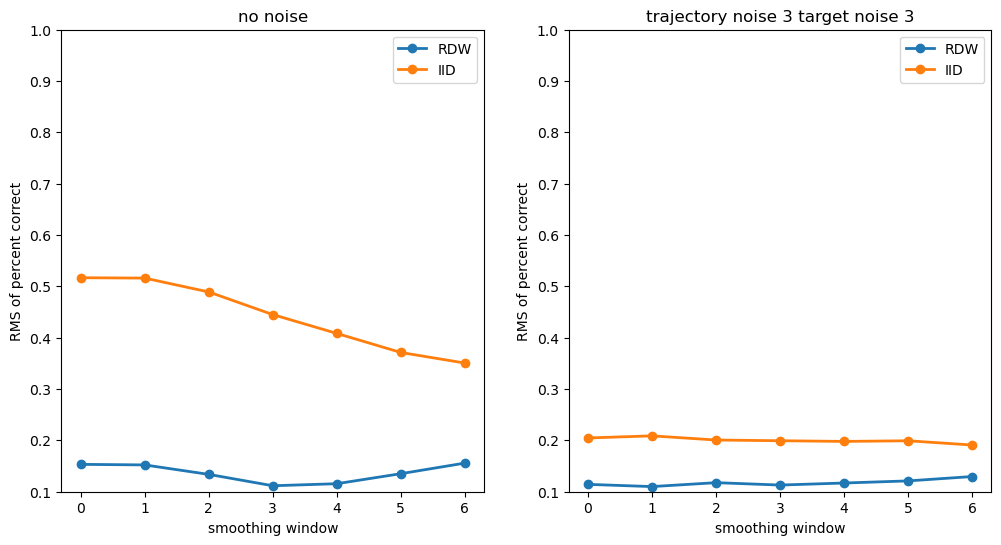

In [69]:
plt.figure(figsize=(12, 6))

# Line plot для 'no noise' condition
plt.subplot(1, 2, 1)
plt.plot(nsmootharr, rmsrdw[0, :, 0], 'o-', label='RDW', linewidth=2)
plt.plot(nsmootharr, rmsiid[0, :, 0], 'o-', label='IID', linewidth=2)
plt.xlabel('smoothing window')
plt.ylabel('RMS of percent correct')
plt.legend()
plt.title('no noise')
plt.ylim([0.1, 1])

# Line plot для 'trajectory noise'
n1, n2 = 3, 3
plt.subplot(1, 2, 2)
plt.plot(nsmootharr, rmsrdw[n1, :, n2], 'o-', label='RDW', linewidth=2)
plt.plot(nsmootharr, rmsiid[n1, :, n2], 'o-', label='IID', linewidth=2)
plt.xlabel('smoothing window')
plt.ylabel('RMS of percent correct')
plt.legend()
plt.title(f'trajectory noise {noisearr[n1]} target noise {noisearr[n2]}')
plt.ylim([0.1, 1])
plt.show()

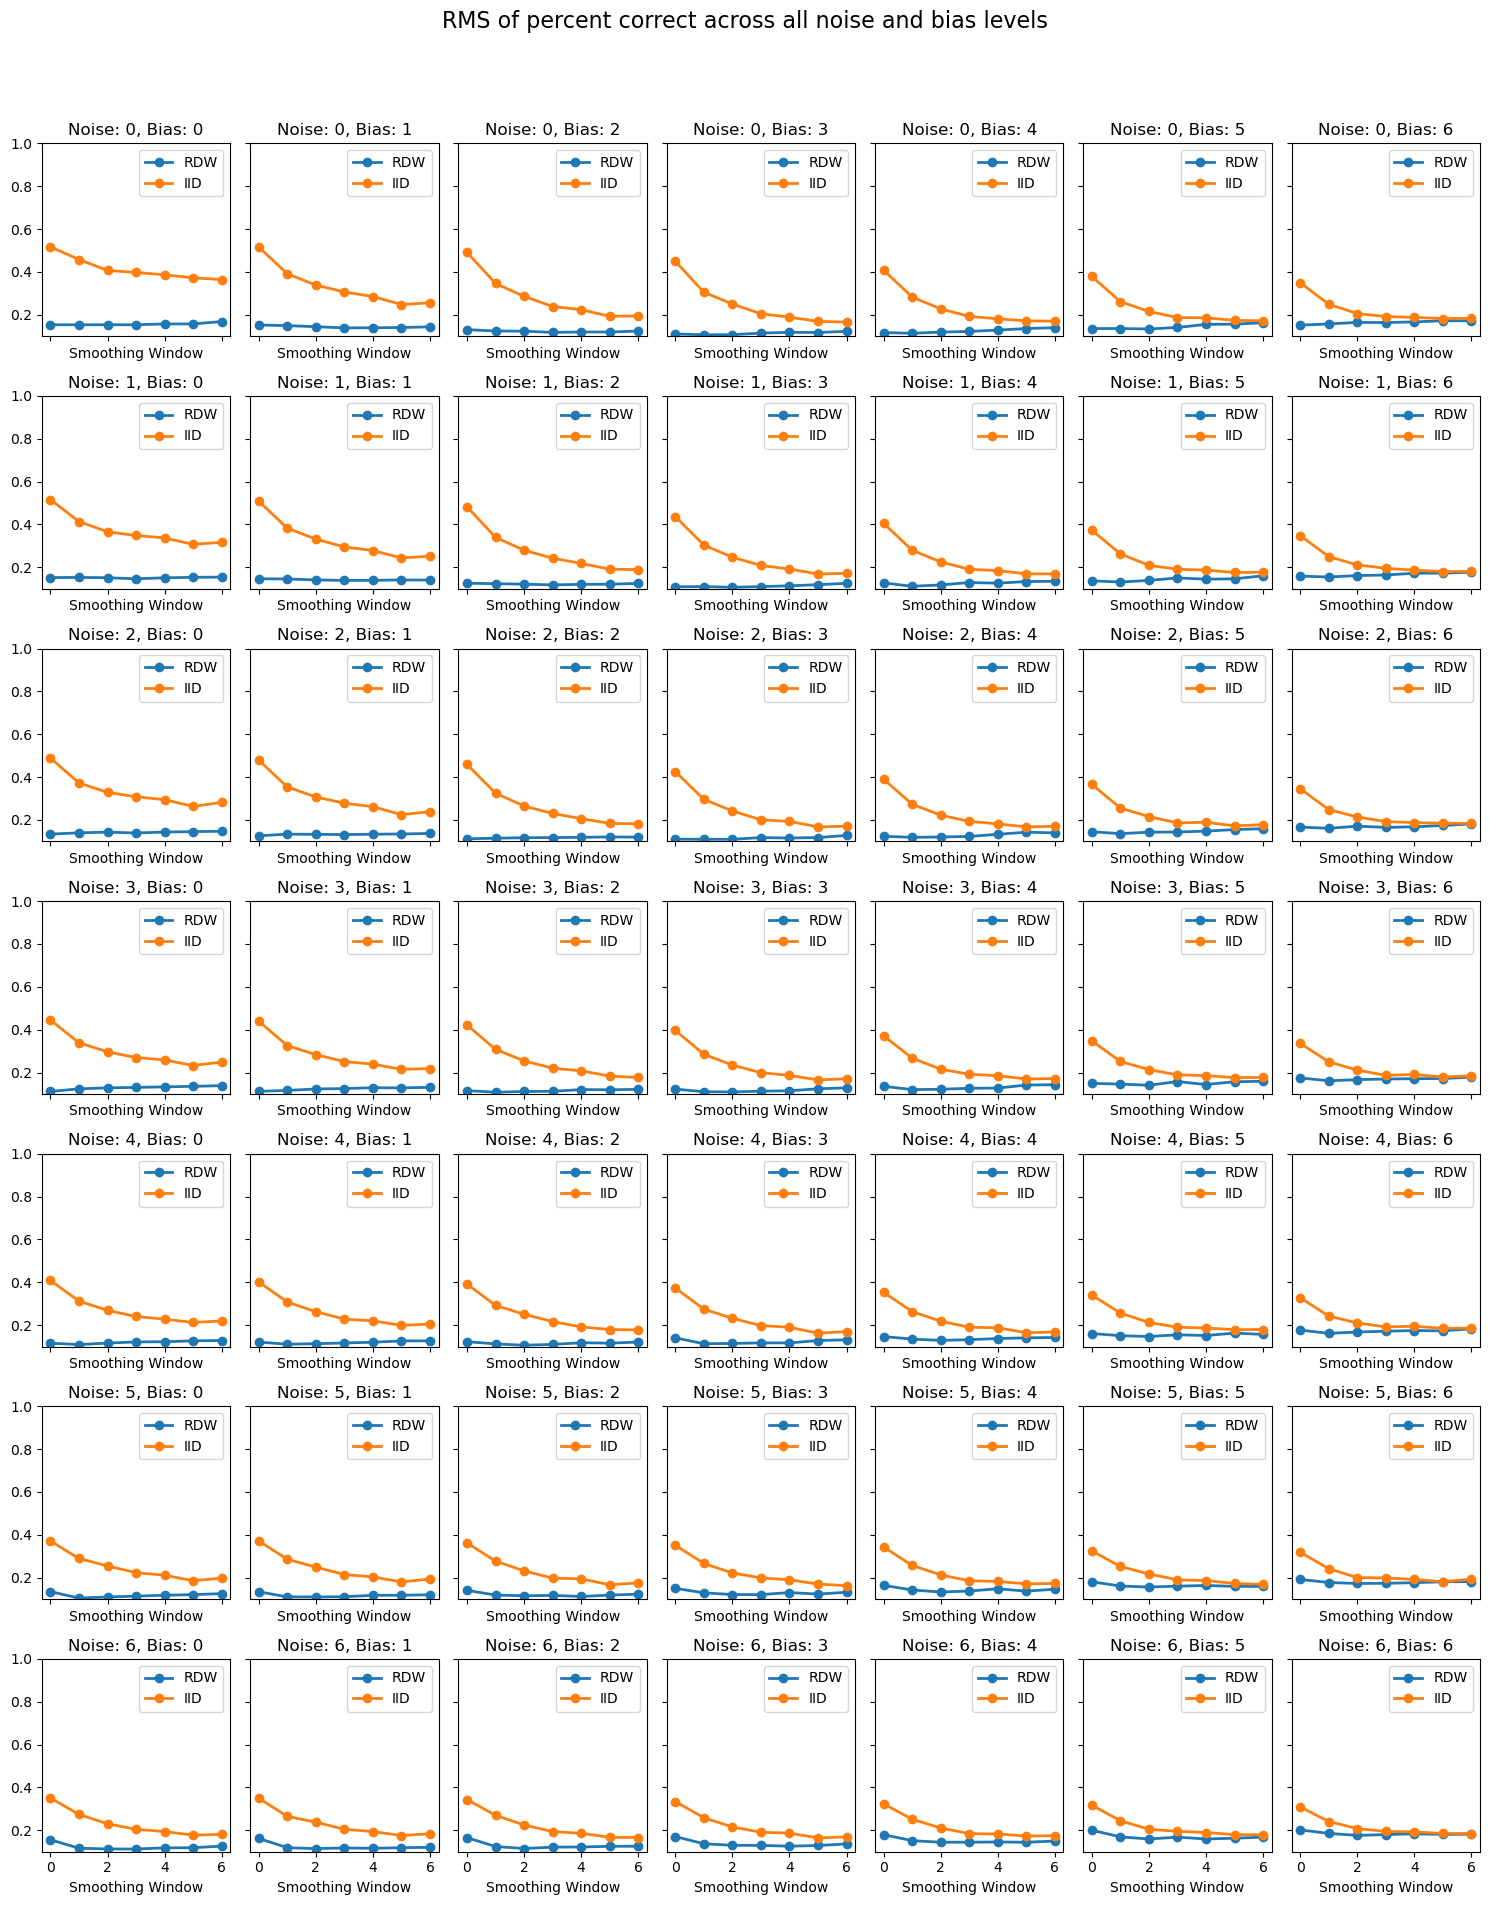

In [70]:
n_rows = len(noisearr)
n_cols = len(nbiasarr)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20), sharex=True, sharey=True)
fig.suptitle('RMS of percent correct across all noise and bias levels', fontsize=16)


for i, noise in enumerate(noisearr):
    for j, bias in enumerate(nbiasarr):
        ax = axes[i, j] if n_rows > 1 and n_cols > 1 else axes[max(i, j)]
        
        ax.plot(nsmootharr, rmsrdw[:, i, j], 'o-', label='RDW', linewidth=2)
        ax.plot(nsmootharr, rmsiid[:, i, j], 'o-', label='IID', linewidth=2)
        # plt.plot(nsmootharr, rmsrdw[i, :, j], 'o-', label='RDW', linewidth=2)
        # plt.plot(nsmootharr, rmsiid[i, :, j], 'o-', label='IID', linewidth=2)
        ax.set_title(f'Noise: {noise}, Bias: {bias}')
        ax.set_xlabel('Smoothing Window')
        # ax.set_ylabel('RMS of percent correct')
        ax.set_ylim([0.1, 1])
        ax.legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

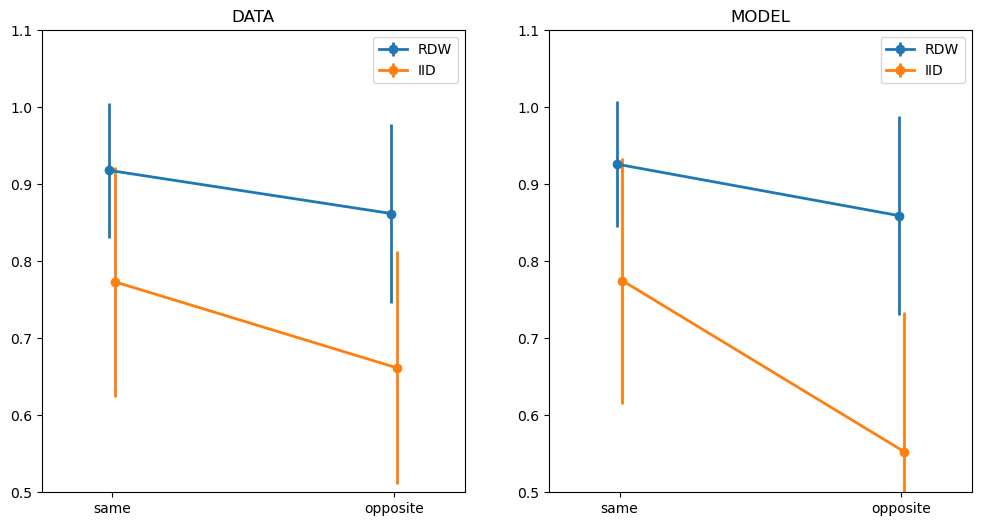

In [71]:
plt.figure(figsize=(12, 6))

# Data error bars
plt.subplot(1, 2, 1)
y1 = corrrslt[1, same[1, :]]
y0 = corrrslt[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='RDW')
y1 = corrrslt[0, same[0, :]]
y0 = corrrslt[0, ~same[0, :]]
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='IID')
plt.xticks([1, 2], ['same', 'opposite'])
plt.xlim([0.75, 2.25])
plt.ylim([0.5, 1.1])
plt.legend()
plt.title('DATA')

# Model error bars
plt.subplot(1, 2, 2)
y1 = minrmdl[1, same[1, :]]
y0 = minrmdl[1, ~same[1, :]]
plt.errorbar([1 - 0.01, 2 - 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='RDW')
y1 = minrmdl[0, same[0, :]]
y0 = minrmdl[0, ~same[0, :]]
plt.errorbar([1 + 0.01, 2 + 0.01], [np.mean(y1), np.mean(y0)], [np.std(y1), np.std(y0)], fmt='-o', linewidth=2, label='IID')
plt.xticks([1, 2], ['same', 'opposite'])
plt.xlim([0.75, 2.25])
plt.ylim([0.5, 1.1])
plt.legend()
plt.title('MODEL')
plt.show()